This notebook is ran on Kaggle and the dataset used is the Graduate Admissions 2 dataset. If you are running this notebook elsewhere, you can use the Kaggle API to download the dataset.

In [545]:
#import required libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import Image, display_svg, SVG
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [546]:
np.random.seed(42)

In [547]:
#load csv into Pandas dataframes
data_df = pd.read_csv('../input/graduate-admissions/Admission_Predict_Ver1.1.csv')

In [548]:
#take a look at the first 5 columns of the dataframes
data_df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


**Exploratory Data Analysis**

In [549]:
#drop the serial no. of the students as we dont need it 
data_df.drop('Serial No.', axis = 1, inplace = True)

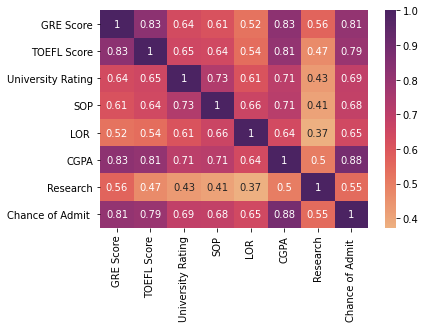

In [550]:
corr = data_df.corr()

#plot correlation matrix heatmap
hm = sns.heatmap(data = corr, annot = True, cmap = sns.color_palette("flare", as_cmap=True)
)

From correlation matrix, it seems like all of the variables are all positively correlated to the chances of admission with CGPA, GRE score and TOEFL score being the highest correlated variable to chances of admission.

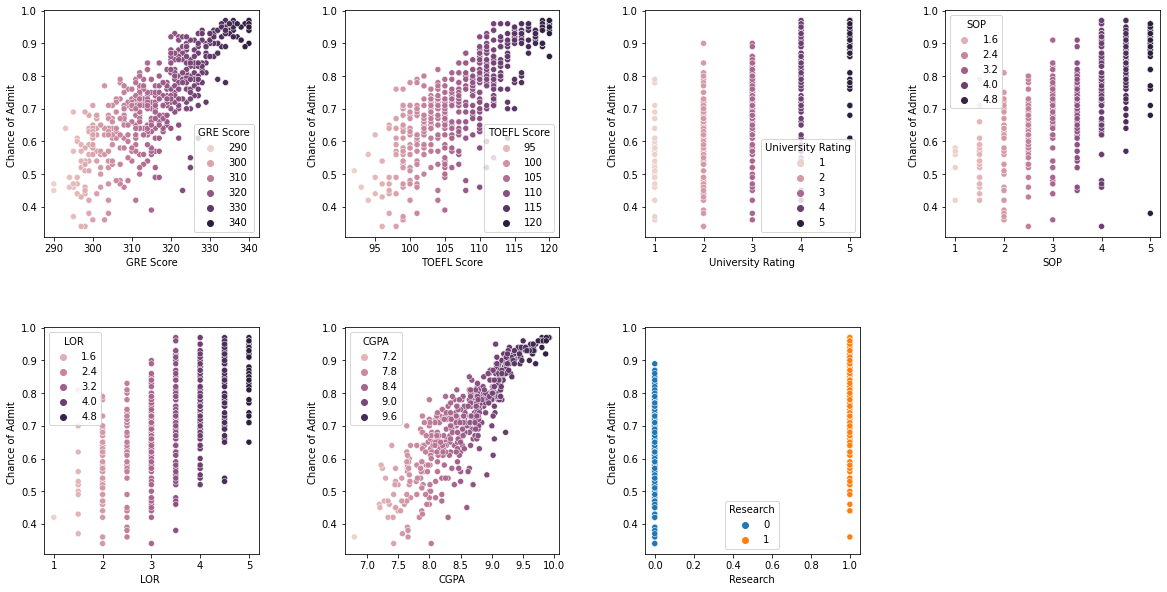

In [551]:
#plot scatter plots of Chance of Admission to each of the variables
column_names = list(data_df.columns)
column_names.pop(-1)

fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(0, len(column_names)):
    ax = fig.add_subplot(2, 4,i+1)
    sns.scatterplot(x = data_df[column_names[i]], y = data_df['Chance of Admit '], hue = data_df[column_names[i]] )
 


**Implement Machine Learning methods**

We will try 3 different models:
1. Multiple Regression model
2. Random Forests
3. Neural Network

In [552]:
#split our data into train and test data
Y = data_df['Chance of Admit ']
X = data_df.drop(columns = {'Chance of Admit '})

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

**Multiple Regression**

We will be using the statsmodels library for regression modelling.
We will fit the model:
Chance of Admission = beta_0 + beta_1 * GRE Score + beta_2 * TOEFL Score + beta_3 * University Rating + beta_4 * SOP + beta_5 * LOr + beta_6 * CGPA + beta_7 * Research

In [553]:
#fit a multiple linear regression model using statsmodels

#add a constant
X1_train = sm.add_constant(X_train)
X1_test = sm.add_constant(X_test)

#fit model
model = sm.OLS(Y_train, X1_train).fit()
predictions = model.predict(X1_test) 

print_model = model.summary()
print(print_model)


#i used statsmodels as it provides additional insights about the model but both would work perfectly fine
#below is the code for fitting with sklearn
"""
from sklearn.linear_model import LinearRegression

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

"""

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Tue, 11 May 2021   Prob (F-statistic):          3.41e-142
Time:                        22:37:44   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4214      0.12

'\nfrom sklearn.linear_model import LinearRegression\n\n# with sklearn\nregr = linear_model.LinearRegression()\nregr.fit(X_train, Y_train)\n\n'

In [554]:
#remove insignificant variables
X2_train = X1_train.drop(columns = ['University Rating', 'SOP'])
X2_test = X1_test.drop(columns = ['University Rating', 'SOP'])


#fit model without the non significant variables
model1 = sm.OLS(Y_train, X2_train).fit()
predictions_significant = model1.predict(X2_test) 

print_model = model1.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     360.8
Date:                Tue, 11 May 2021   Prob (F-statistic):          1.36e-144
Time:                        22:37:44   Log-Likelihood:                 561.54
No. Observations:                 400   AIC:                            -1111.
Df Residuals:                     394   BIC:                            -1087.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4555      0.116    -12.517      

In [555]:
(mean_squared_error(predictions, Y_test), mean_squared_error(predictions_significant, Y_test))

(0.0037046553987884084, 0.0037730207651169123)

**Random Forest**

In [556]:
forest = RandomForestRegressor(n_estimators=1100,max_depth =6 ,max_features = 0.5)
forest.fit(X_train, Y_train)
predictions_rf = forest.predict(X_test)
mean_squared_error(predictions_rf, Y_test)

0.003921688103665227

In [557]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [558]:
#check most important features
fi = rf_feat_importance(forest, X_train)
fi

,cols,imp
5,CGPA,0.438764
0,GRE Score,0.277015
1,TOEFL Score,0.143017
3,SOP,0.052103
2,University Rating,0.046332
4,LOR,0.028551
6,Research,0.014219


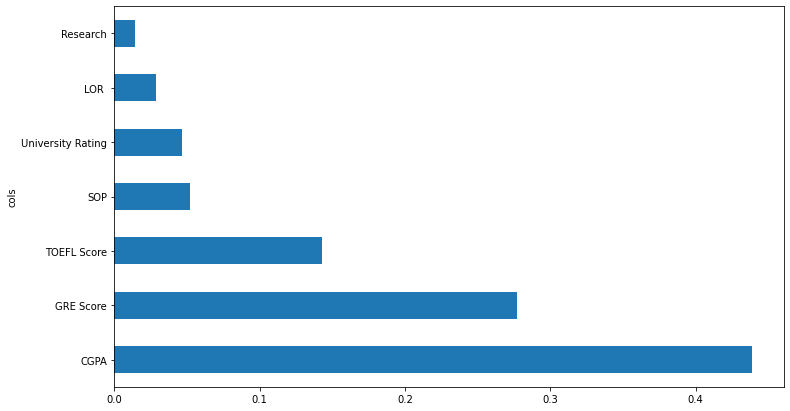

In [559]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

In [560]:
to_keep = fi[fi.imp>0.01].cols
len(to_keep) == len(X_train.columns)

True

In [561]:
mean_squared_error(predictions_rf, Y_test)

0.003921688103665227

**Neural Network**

In [562]:
train_df = X_train
test_df = X_test
train_df = train_df.join(Y_train)
test_df = test_df.join(Y_test)

#split the variables into continuous variables and categorical variables using fastai's factory method
cont_nn,cat_nn = cont_cat_split(train_df, dep_var='Chance of Admit ')



In [563]:
#create dataloaders
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_df, procs_nn, cat_nn, cont_nn, y_names='Chance of Admit ',splits = RandomSplitter(valid_pct=0.4)(range_of(train_df))
)
dls = to_nn.dataloaders()


In [564]:
dls.show_batch()

,University Rating,Research,GRE Score,TOEFL Score,SOP,LOR,CGPA,Chance of Admit
0,4,0,308.000000,110.0,3.5,3.0,8.60,0.70
1,4,1,321.000000,111.0,4.0,4.0,8.97,0.87
2,4,1,330.999999,116.0,4.5,4.5,9.44,0.92
3,4,0,314.000000,104.0,5.0,5.0,9.02,0.82
4,3,1,321.000000,111.0,2.5,3.0,8.90,0.80
5,2,0,306.000000,103.0,2.5,3.0,8.36,0.69
6,3,1,325.000000,107.0,3.0,3.5,9.11,0.84
7,2,0,311.000000,104.0,2.5,3.5,8.48,0.71
8,3,1,317.000000,107.0,3.5,3.0,8.68,0.84
9,5,1,324.000000,114.0,5.0,4.5,9.08,0.89


In [565]:
#create tabular learner
learn = tabular_learner(dls, y_range=(0.3,1),n_out=1, loss_func=F.mse_loss)


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0012022644514217973)

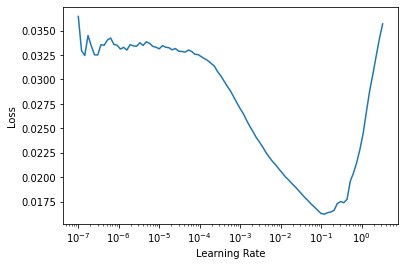

In [566]:
learn.lr_find()


In [567]:
learn.fit_one_cycle(15, 1e-2)


epoch,train_loss,valid_loss,time
0,0.028705,0.018757,00:00
1,0.018790,0.010570,00:00
2,0.014203,0.005702,00:00
3,0.011694,0.004854,00:00
4,0.010198,0.005083,00:00
5,0.009138,0.004454,00:00
6,0.008242,0.004350,00:00
7,0.007529,0.004237,00:00
8,0.006922,0.004726,00:00
9,0.006482,0.004443,00:00


In [568]:
test_df.drop(['Chance of Admit '], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

preds = learn.get_preds(dl=dl)

#convert the predictions into a list
y = []
for i in range(0,len(Y_test)):
    x = preds[0][i].tolist()
    y += x
    
mean_squared_error(y,Y_test)

0.0037736961901234677

**Ensembling the models**

In [569]:
ens_preds = (predictions + predictions_rf + y) /3
mean_squared_error(ens_preds, Y_test)


0.003607077516281899

**Conclusion**

In [570]:
conclusion = pd.DataFrame()
conclusion['Method'] = ['Linear Regression', 'Random Forest', 'Neural Network', 'Ensemble']
conclusion['Mean Square Error'] = [mean_squared_error(predictions,Y_test), mean_squared_error(predictions_rf,Y_test), 
                                   mean_squared_error(y,Y_test),mean_squared_error(ens_preds, Y_test)]

In [571]:
conclusion

,Method,Mean Square Error
0,Linear Regression,0.003705
1,Random Forest,0.003922
2,Neural Network,0.003774
3,Ensemble,0.003607
